In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib, json
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

import os
path_to_output_folder = './output_cvm/dre/'

In [2]:
cvm_folders = [cvm_folder for cvm_folder in os.listdir(path_to_output_folder)]
total = len(cvm_folders)
count=0
df = pd.DataFrame()
for cvm_folder in cvm_folders:
    count=count+1
    for grupo in ['consolidado', 'individual']:
        path =path_to_output_folder+cvm_folder+'/'+grupo
        if os.path.exists(path):
            json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
            for file in json_files:
                with open(path_to_output_folder+'/'+cvm_folder + '/' + grupo + '/' + file) as json_file:
                    fileData = json.load(json_file)
                    newDF = pd.DataFrame(fileData['data'])
                    #Drop not usefull columns
                    newDF=newDF.drop(['CD_CONTA', 'NIVEL','TRIM_VL','AH','TTM', 'AV', 'MARGEM_TRIM', 'MARGEM_ANO', 'MARGEM_TTM', 'TRIM_ANO'], axis=1)
                    df=df.append(newDF, ignore_index=True)

In [3]:
#Filter by Year and Trimester 4
year = 2019
trim = 3
dfYear=df[(df.YEAR==year) & (df.TRIM==trim)]
#Filter to only show 'IMPOSTO' 'EBIT' 'EBT'
dfYear = dfYear[(dfYear.DESC_SIMPLES=='Impostos') | (dfYear.DESC_SIMPLES=='EBIT') | (dfYear.DESC_SIMPLES=='EBT') ]

R = pd.DataFrame([], columns=['cvm','company','taxRate']);
count=0
for cvm in dfYear.CD_CVM.unique():
    #filter by CVM
    D = dfYear[dfYear.CD_CVM==cvm]
    #Check if there is CONSOLIDADO
    if(D[D.GRUPO_DFP=='Consolidado'].size):
        D = D[D.GRUPO_DFP=='Consolidado']
    ebt = D[D.DESC_SIMPLES=='EBT']
    tax = D[D.DESC_SIMPLES=='Impostos'] 
    if(ebt.size & tax.size):
        count=count+1
        ebt=ebt.VL_CONTA.values[0]
        tax=tax.VL_CONTA.values[0]
        taxRate = (-1)*tax/ebt
        R=R.append(pd.DataFrame([{'cvm': cvm, 'company': D.DENOM_CIA.values[0], 'taxRate': taxRate}]), ignore_index=True)

R_OverZero=R[(R.taxRate>0)]
print(str(len(R_OverZero))+'/'+str(len(R)))


397/556


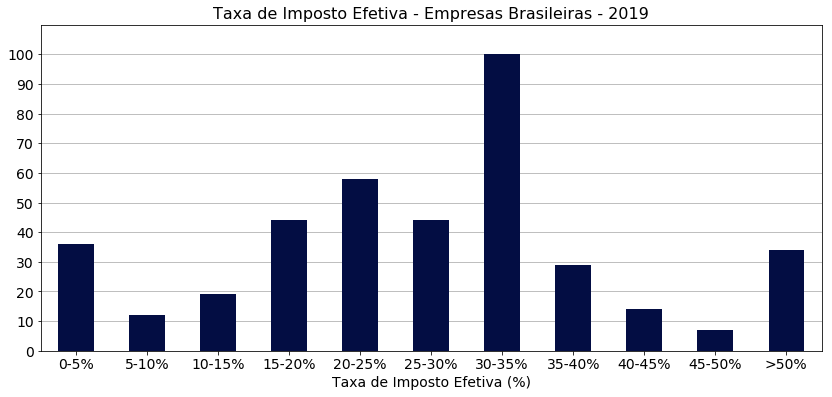

In [4]:
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

fig, ax =  plt.subplots(figsize=(14,6))
# plt.figure(figsize=(1,1))
ax.set_axisbelow(True)
plt.grid(axis='y')
plt.yticks(np.arange(0,110, step=10),fontsize=14)
plt.ylim([0,110])
plt.xlabel('Taxa de Imposto Efetiva (%)', fontsize=14)
plt.title(r'Taxa de Imposto Efetiva - Empresas Brasileiras - ' + str(year), fontsize=16)
bins = np.linspace(0,55,12)
counts, bins, patches = ax.hist(np.clip(R_OverZero.taxRate*100, bins[0], bins[-1]), bins=bins, rwidth=.5, color='#030D43')
bins_labels(bins, fontsize=14)
plt.autoscale(enable=False, axis='y')

# Set the ticks to be at the edges of the bins.
# ax.set_xticks(bins)
# Set the xaxis's tick labels to be formatted with 1 decimal place...
#ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
names=['0-5%','5-10%','10-15%','15-20%','20-25%','25-30%','30-35%','35-40%','40-45%','45-50%','>50%']
ax.set_xticklabels(names,rotation=0)
plt.savefig('./output_cvm/fig/'+'tax'+str(year)+'.png', transparent=True, bbox_inches='tight')

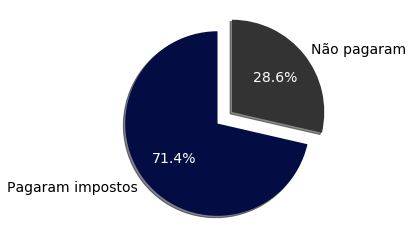

In [6]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pagaram impostos', 'Não pagaram', 
sizes = [len(R_OverZero), len(R)-len(R_OverZero)]
explode = (0.2,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors=['#030D43','#333333']
fig1, ax1 = plt.subplots()
_, _, autotexts = ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors,  labels=labels, textprops={'fontsize': 14})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
for autotext in autotexts:
    autotext.set_color('white')

# plt.show()
plt.savefig('./output_cvm/fig/'+'taxPie'+str(year)+'.png', transparent=True, bbox_inches='tight')